# Shortlisting Players for a Champions League Club

In this notebook I will attempt to shortlist players from the provided data for a Champions League club. In particular, the team is looking for a **Defensive Midfielder**, a **Centre Back** and a **Winger**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patheffects, lines
from matplotlib.patches import Circle
from datetime import datetime, date
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import preprocessing

plt.style.use('football')

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 3)

In [3]:
df = pd.read_csv("data_analyst_task_data.csv")

In [4]:
print("There are",len(df['team_id'].unique()),"teams in the data set.")

There are 20 teams in the data set.


In [5]:
print("There are",len(df['player_id'].unique()),"unique players in the data set.")

There are 603 unique players in the data set.


In [8]:
df.head()

,player_id,player_birth_date,game_id,position,touches,team_id,mins_played,game_started,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded
0,56448,1991-02-16,869636,Midfielder,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0
1,140264,1990-05-24,869728,Midfielder,64,953,90,1,8,2,2,2,2,1,3,3,0,0,1,7,0,7,0,51,13,0,44,0,0,0,0,0,0,2,0,0.051,0,0,0,0,0,1
2,126290,1991-07-18,869481,Midfielder,34,953,90,1,1,2,2,0,2,2,3,1,0,0,1,2,4,14,2,14,2,0,8,0,0,0,1,1,4,1,0,0.058,1,0,0,0,0,1
3,58906,1986-11-21,869573,Midfielder,15,616,21,0,1,0,0,0,0,1,1,2,0,0,1,1,0,1,0,9,2,0,9,0,0,0,0,1,0,0,0,0.000,0,0,0,0,0,0
4,39817,1984-06-12,869642,Midfielder,96,449,90,1,11,2,2,1,0,1,3,1,0,0,0,20,2,8,0,87,2,0,80,0,0,1,0,1,0,0,0,0.000,0,0,0,0,0,2


Total minutes played by each player.

In [9]:
df_players = pd.DataFrame(df.groupby('player_id')['mins_played'].sum())

Then get 90s played.

In [10]:
df_players['90s'] = df_players['mins_played']/90

Age.

In [11]:
def calculate_age(birth_date):
    today = date.today()
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    return age

In [12]:
birth_dates = []
for pid in df_players.index:
    player = df[df['player_id'] == pid]
    birth_date = datetime.strptime(player['player_birth_date'].iloc[0], "%Y-%m-%d").date()
    birth_dates.append(calculate_age(birth_date))

In [13]:
df_players['age'] = birth_dates

Games played and number of starts.

In [14]:
df_players['gp'] = df.groupby('player_id').size()
df_players['games_started'] = df.groupby('player_id')['game_started'].sum()

Position of each player. First check that the position of a player does not change.

In [15]:
for pid in df['player_id'].unique():
    if len(df[df['player_id'] == 140264]['position'].value_counts()) < 1:
        print('More than one position')

We see that every player has a single position. Now find position of every player.

In [16]:
df_players['position'] = np.ravel(df.groupby('player_id')['position'].unique().to_list())

In [17]:
df_players.head()

,mins_played,90s,age,gp,games_started,position
player_id,,,,,,
7088,2051,22.789,38,32,22,Defender
7261,540,6.000,39,16,6,Defender
10316,1675,18.611,39,31,19,Midfielder
10343,864,9.600,36,30,10,Midfielder
11129,3240,36.000,30,36,36,Defender


## Winger

In [18]:
wing_attr = ['touches','final_third_entries','pen_area_entries','poss_lost_all','total_cross','total_pass','total_long_balls',
 'total_through_ball','accurate_pass','accurate_through_ball','accurate_cross','total_att_assist','won_contest',
'total_contest','touches_in_opp_box','total_scoring_att','goals','expected_goals','ontarget_scoring_att']

In [19]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#004d98', '#edbb00', '#a50044', 'xkcd:green', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


Think about whether every attribute is better if it is higher. `poss_lost_all` is the only one, that I can see, that is clearly worse when it has a higher value. Therefore, we should flip the percentile rank by doing 100 minus the current percentile rank. Now a higher value is a lower rank.

In [20]:
def calculate_age(birth_date):
    today = date.today()
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    return age

In [21]:
def get_df_pos(df,attr,nineties=10,age_range=None,exclude_pos=['Goalkeeper']):
    """ Function to get two dataframes of players with the per 90 and per 90 percentiles of the specified relevent 
    attributes. """
    all_attr = [i for i in df.columns if i not in ['player_id', 'player_birth_date', 'game_id', 'position','team_id', 'mins_played', 'game_started']]
    
    # Create a player dataframe with personal stats
    df_players = pd.DataFrame(df.groupby('player_id')['mins_played'].sum())
    df_players['90s'] = df_players['mins_played']/90
    birth_dates = []
    for pid in df_players.index:
        player = df[df['player_id'] == pid]
        birth_date = datetime.strptime(player['player_birth_date'].iloc[0], "%Y-%m-%d").date()
        birth_dates.append(calculate_age(birth_date))
    df_players['age'] = birth_dates
    df_players['gp'] = df.groupby('player_id').size()
    df_players['games_started'] = df.groupby('player_id')['game_started'].sum()
    df_players['position'] = np.ravel(df.groupby('player_id')['position'].unique().to_list())
    
    # Create dataframe of player stat totals
    df_total = pd.concat([df_players, df.groupby('player_id')[all_attr].sum()], axis=1)
    df_total['xG/shot'] = df_total['expected_goals'] / df_total['total_scoring_att']
    df_total['pass%'] = df_total['accurate_pass'] / df_total['total_pass']
    df_total['cross%'] = df_total['accurate_cross'] / df_total['total_cross']
    df_total['contest%'] = df_total['won_contest'] / df_total['total_contest']
    df_total.fillna(0,inplace=True)
    # Player stat p90 values
    df_total_p90 = pd.concat([df_players,df_total.groupby('player_id')[all_attr].sum().div(df_players['90s'], axis=0).fillna(0)], axis=1)
    df_total_p90['xG/shot'] = df_total['xG/shot']
    df_total_p90['pass%'] = df_total['pass%']
    df_total_p90['cross%'] = df_total['cross%']
    df_total_p90['contest%'] = df_total['contest%']
    
    # Create dataframe focusing on the specified important stats
    df_pos = df_total[['mins_played', '90s', 'age', 'gp', 'games_started', 'position']+attr]
    df_pos_p90 = df_total_p90[['mins_played', '90s', 'age', 'gp', 'games_started', 'position']+attr]
    
    # Filter by 90s played
    df_pos_p90 = df_pos_p90[df_pos_p90['90s'] >= nineties].copy()
    # Excluding positions
    if exclude_pos:
        df_pos_p90 = df_pos_p90[~df_pos_p90['position'].isin(exclude_pos)].copy()
    # Age range
    if age_range:
        df_pos_p90 = df_pos_p90[(df_pos_p90['age'] >= age_range[0])&(df_pos_p90['age'] <= age_range[1])].copy()
        
    # Calculate percentiles
    df_pos_p90_per = df_pos_p90.copy()
    for a in attr:
        df_pos_p90_per[a] = df_pos_p90[a].apply(lambda x: stats.percentileofscore(df_pos_p90[a],x))
    # Flip 'poss_lost_all' since lower is better
    if 'poss_lost_all' in attr:
        df_pos_p90_per['poss_lost_all'] = 100 - df_pos_p90_per['poss_lost_all']
    
    return df_pos_p90, df_pos_p90_per

In [22]:
wing_shot_attr = ['expected_goals','total_scoring_att','xG/shot']
wing_pass_attr = ['total_att_assist','total_pass','pass%']
wing_cross_attr = ['total_cross','cross%']
wing_drib_attr = ['total_contest','contest%']

In [23]:
wing_attr_key = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','pass%',
                 'total_cross','touches_in_opp_box','won_contest','poss_lost_all']

In [24]:
wing_attr_key2 = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','total_pass','pass%',
                  'total_cross','cross%','touches_in_opp_box','total_contest','contest%','poss_lost_all']

In [25]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key2,nineties=20,exclude_pos=['Goalkeeper','Defender'])

In [34]:
def plot_bars(df_players,df_pos_p90,df_pos_p90_per,attrs,pid,bar_cmap='RdYlGn',annotations=True,ax=None,
              attr_labels=['xG','Shots','xG/Shot','Key Passes','Passing %','Crosses','Touches in Box','Successful Dribbles','Poss. Losses']):
    
    df_pos_p90 = df_pos_p90[attrs]
    df_pos_p90_per = df_pos_p90_per[attrs]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    cmap = plt.get_cmap(bar_cmap)
    norm = mpl.colors.Normalize(vmin=0, vmax=100)

    y_range = np.arange(len(attrs),0,-1)

    ax.barh(np.arange(len(attrs),0,-1),df_pos_p90_per.loc[pid].values - 50,left=50,color=cmap(norm(df_pos_p90_per.loc[pid].values)))
    ax.axvline(50,c='k',lw=1,ls='--')
    for i,attr in enumerate(attrs):
        if df_pos_p90_per.loc[pid,attr] >= 50:
            ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',fontsize=14,color='k',path_effects=[patheffects.withStroke(linewidth=4,foreground="w")])
        else:
            if df_pos_p90_per.loc[pid,attr] <= 25:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(51,y_range[i]),annotation_clip=False,ha='left',va='center',fontsize=14,path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',fontsize=14,path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])

    #attr_labels = ['xG','Shots','xG/Shot','Key Passes','Passing %','Crosses','Touches in Box','Successful Dribbles','Poss. Losses']
    ax.set_xlim(0,100)
    ax.set_yticks(np.arange(len(attrs),0,-1))
    ax.set_yticklabels(attr_labels)
    ax.set_xticks(np.arange(0,125,25))
    ax.tick_params(bottom=False,left=False,labelbottom=False)
    for i in ['top','bottom']:
        ax.spines[i].set_visible(False)

    ax.grid(axis='x',ls='--',alpha=1)
    ax.text(0.5,1,'Median',ha='center',va='bottom',transform=ax.transAxes)
    
    if annotations:
        ax.text(0,1.22,"Player ID: {}".format(pid),transform=ax.transAxes,fontsize=18,fontweight='bold',ha='left',va='bottom')
        ax.text(0,1.15,"{}".format(df_players.loc[pid,'position']),transform=ax.transAxes,fontsize=16,fontweight='normal',ha='left',va='bottom')
        ax.text(0,1.1,"Values per 90 minutes played",transform=ax.transAxes,fontsize=12,fontweight='normal',ha='left',va='bottom')

        ax.text(1.,1.22,"Age: {}".format(df_players.loc[pid,'age']),transform=ax.transAxes,fontsize=16,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.15,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=ax.transAxes,fontsize=16,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.1,"{} Games Played, {} Starts".format(df_players.loc[pid,'gp'],df_players.loc[pid,'games_started']),transform=ax.transAxes,fontsize=12,fontweight='normal',ha='right',va='bottom')

        #line = lines.Line2D([-10,110], [10.5,10.5], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        line = lines.Line2D([-0.1,1.1], [1.05,1.05], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        ax.add_line(line)

        ax.text(0.5,-0.1,"Compared to all players who have played at least 10 90s.",transform=ax.transAxes,fontsize=12,fontweight='normal',ha='center',va='bottom')

    plt.show()
    
    return ax

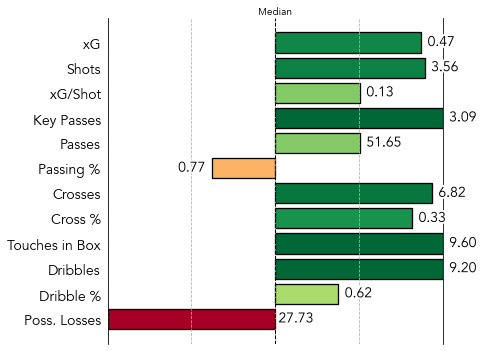

In [35]:
attr_labels = ['xG','Shots','xG/Shot','Key Passes','Passes','Passing %','Crosses','Cross %','Touches in Box','Dribbles','Dribble %','Poss. Losses']
plot_bars(df_players,df_pos_p90,df_pos_p90_per,wing_attr_key2,61278,attr_labels=attr_labels,annotations=False)

#### Box plots

In [40]:
# Select quick top 10 from summed percentiles in key attr
top10 = df_pos_p90_per[wing_attr_key2].sum(axis=1).sort_values(ascending=False).iloc[:10].index
df_top10 = df_pos_p90[wing_attr_key2].loc[top10]
df_top10_per = df_pos_p90_per[wing_attr_key2].loc[top10]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


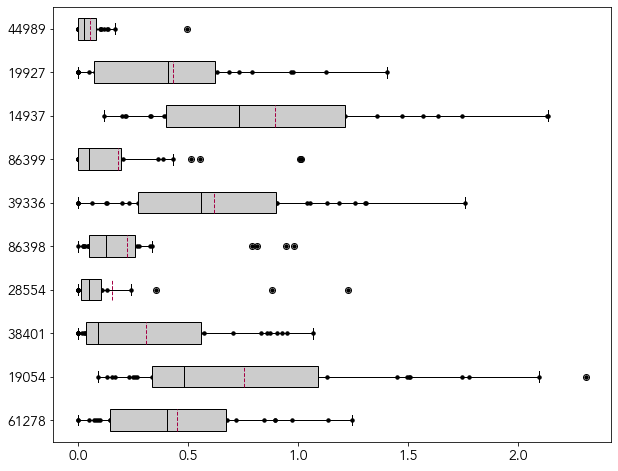

In [41]:
fig,ax = plt.subplots(figsize=(10,8))

players = df_top10.index.to_list()

data = []
for i,p in enumerate(players):
    vals = df[df['player_id'] == p]['expected_goals'].to_list()
    data.append(vals)
    ax.scatter(vals,[i+1]*len(vals),s=10,c='k',zorder=1)
    #np.array(data, dtype=object)
    
bplot = ax.boxplot(data,vert=False,labels=players,patch_artist=True,showmeans=True,meanline=True,medianprops={'color':'k'},zorder=1)
#ax.scatter(data,[i+1]*len(data))

for patch in bplot['boxes']:
    patch.set_facecolor('0.8')
    #patch.set_alpha(0.8)

plt.show()

### Player Style

To determine a player's playing style I will use Principal Component Analysis (PCA) in combination with different groups of attributes that I believe correspond to different styles. Looking at the features of the data, we could separte into *Shooting*, *Passing*, *Dribbling* and *Crossing* preferences. Since I am aiming to determine style here I will focus on attributes that specify quantity rather than quality.

In [42]:
shot_attr = ['total_scoring_att','expected_goals']
pass_attr = ['total_pass','total_through_ball','total_att_assist']
drib_attr = ['total_contest']
cross_attr = ['total_cross']
style_attr = shot_attr + pass_attr + drib_attr + cross_attr

With the attributes of each group specified, the next step is to perform PCA on each group separately to combine the features of each group into a single feature that describes how important that group is to a player's style.

In [43]:
def change_range(value,old_range,new_range):
    return ((value - old_range[0])/(old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]

Get the data. I will use all midfielders and forwards who have played at least 10 90s.

In [44]:
df_pca_p90,df_pca_p90_per = get_df_pos(df,style_attr,nineties=10,exclude_pos=['Goalkeeper','Defender'])

Perform PCA on each group. I will use the percentile ranks as the value for each player in each attribute rather than the raw value.

In [45]:
cols = ['shot','pass','drib','cross']
df_style = pd.DataFrame(index=df_pca_p90_per.index)
for i,group in enumerate([shot_attr,pass_attr,drib_attr,cross_attr]):
    X = preprocessing.scale(df_pca_p90_per[group])
    pca = PCA(n_components=1)
    df_style[cols[i]] = pca.fit_transform(X)

df_style = df_style.apply(lambda x: change_range(x,(x.min(),x.max()),(0,1)))

In [46]:
df_style.head()

,shot,pass,drib,cross
player_id,,,,
10316,0.485,0.555,0.839,0.892
12237,0.245,0.937,0.720,0.456
14402,0.927,0.233,0.737,0.261
14464,0.946,0.303,0.452,0.402
14937,1.000,0.391,0.624,0.515


Function for plotting a radar of the styles for a player.

In [47]:
def plot_style(df_style,pid,colors=None,labels=['Shooting','Passing','Dribbling','Crossing'],ax_rad=None):
    if ax_rad is None:
        fig = plt.figure(figsize=(5,5))
        ax_rad = fig.add_subplot(111, projection='polar')

    # Plot bars
    bot = 0.3
    radii = df_style.loc[pid].to_numpy()
    theta = np.linspace(np.pi/len(radii),2*np.pi+np.pi/len(radii),len(radii),endpoint=False)
    bars = ax_rad.bar(theta,radii,width=2*np.pi/len(radii),bottom=bot)

    # Set bar properties
    if colors is None:
        colors = ['#f38181', '#fce38a', '#eaffd0', '#95e1d3']
    for i,bar in enumerate(bars):
        bar.set_alpha(0.8)
        bar.set_ec('k')
        bar.set_fc(colors[i])
        bar.set_lw(3)

    # Add thin lines separating sections
    angles = np.linspace(0,2*np.pi,len(radii),endpoint=False)
    for a in angles:
        ax_rad.plot([a,a],[0,1+bot],c='k',lw=1,zorder=1)

    # Add central white circle
    patch = Circle((0,0),radius=bot,fc='w',transform=ax_rad.transProjectionAffine + ax_rad.transAxes,zorder=2)
    ax_rad.add_patch(patch)

    # Annotations
    for i,ang in enumerate(theta):
        if ang < np.pi:
            ax_rad.annotate(labels[i],(ang,1.2+bot),fontsize=16,fontweight='bold',annotation_clip=False,ha='left')
            if radii[i] <= 0.5:
                ax_rad.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=20,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax_rad.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=20,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
        else:
            ax_rad.annotate(labels[i],(ang,1.2+bot),fontsize=16,fontweight='bold',annotation_clip=False,ha='right')
            if radii[i] <= 0.5:
                ax_rad.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=20,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax_rad.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=20,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])

    ax_rad.set_ylim(0,1+bot)
    ax_rad.set_theta_zero_location('N')
    ax_rad.set_theta_direction(-1)
    ax_rad.set_xticks(theta)
    ax_rad.set_yticklabels([])
    ax_rad.set_xticklabels([])
    ax_rad.xaxis.grid(False)
    ax_rad.yaxis.grid(False)
    ax_rad.spines['polar'].set_visible(True)
    ax_rad.spines['polar'].set_linewidth(1)
    
    return ax_rad

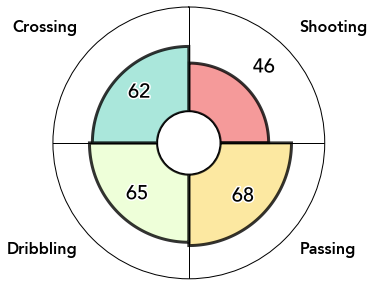

In [48]:
plot_style(df_style,39441)

### Team Style

For team style I will follow a similar analysis to player styles.

In [51]:
all_attr = [i for i in df.columns if i not in ['player_id', 'player_birth_date', 'game_id', 'position','team_id', 'mins_played', 'game_started']]

In [52]:
df_team = df.groupby('team_id')[all_attr].sum()

In [53]:
df_team.head()

,touches,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded
team_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
173,21938,2273,444,764,535,684,591,565,539,2,1,927,1959,923,5570,636,14473,2756,20,11058,12,162,284,330,583,523,395,41,44.789,134,121,97,72,49,472
174,23943,2421,495,799,565,780,614,566,517,4,6,621,2439,1322,6247,903,16207,2799,26,12300,14,205,355,347,658,842,487,53,53.659,186,81,80,55,26,470
175,25069,2407,503,849,589,610,535,618,498,6,0,769,2448,1173,5854,649,17211,2334,39,13585,23,142,380,408,788,853,505,70,62.771,198,88,162,57,30,296
176,25051,2455,438,791,538,544,620,599,514,5,7,722,2348,882,5818,480,17820,2677,36,14081,19,106,299,320,596,643,404,52,41.233,149,121,56,76,45,751
177,22178,2241,461,816,561,548,643,590,567,3,2,827,1932,870,5644,672,14833,2666,17,11237,7,146,238,318,621,522,343,48,33.562,128,127,90,73,53,544


In [54]:
df_team_per = df_team.copy()
for a in style_attr:
        df_team_per[a] = df_team[a].apply(lambda x: stats.percentileofscore(df_team[a],x))

In [55]:
cols = ['shot','pass','drib','cross']
df_style_team = pd.DataFrame(index=df_team_per.index)
for i,group in enumerate([shot_attr,pass_attr,drib_attr,cross_attr]):
    X = preprocessing.scale(df_team_per[group])
    pca = PCA(n_components=1)
    df_style_team[cols[i]] = pca.fit_transform(X)

df_style_team = df_style_team.apply(lambda x: change_range(x,(x.min(),x.max()),(0,1)))

In [56]:
df_style_team.head()

,shot,pass,drib,cross
team_id,,,,
173,0.324,0.193,0.263,0.684
174,0.730,0.514,0.684,0.053
175,0.865,0.734,0.947,0.579
176,0.270,0.521,0.368,0.947
177,0.000,0.067,0.579,0.316


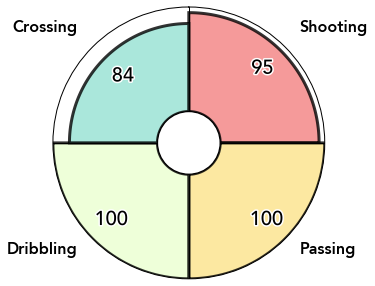

In [57]:
plot_style(df_style_team,178)

### Combined plot

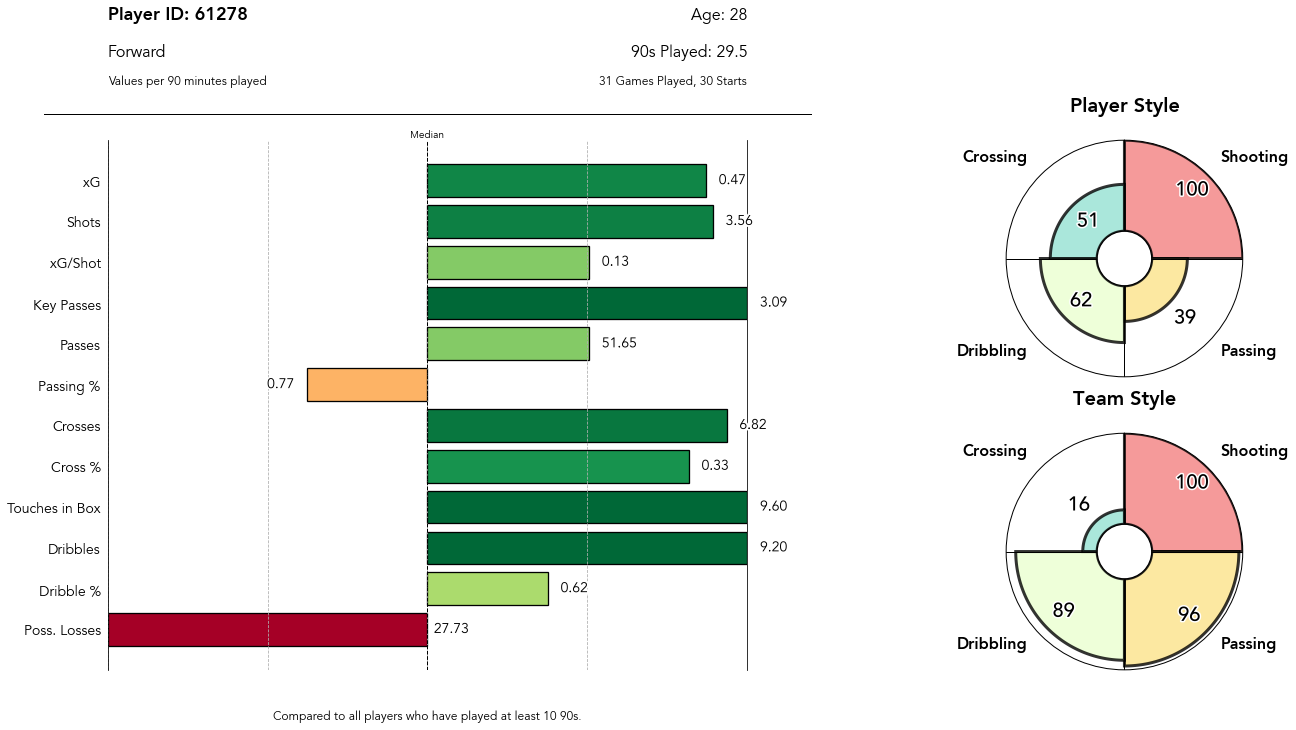

In [60]:
pid = 14937
tid = df[df['player_id'] == pid]['team_id'].iloc[0]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
gs = fig.add_gridspec(2, 2, width_ratios=[1,1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1],projection='polar')
ax3 = fig.add_subplot(gs[1, 1],projection='polar')

ax2 = plot_style(df_style,pid,ax_rad=ax2)
ax2.text(0.5,1.1,"Player Style",transform=ax2.transAxes,fontsize=20,fontweight='bold',ha='center',va='bottom')

ax3 = plot_style(df_style_team,tid,ax_rad=ax3)
ax3.text(0.5,1.1,"Team Style",transform=ax3.transAxes,fontsize=20,fontweight='bold',ha='center',va='bottom')

ax1 = plot_bars(df_players,df_top10,df_top10_per,wing_attr_key2,61278,attr_labels=attr_labels,ax=ax1)


#plt.tight_layout()

### Winger Shortlist

When creating a winger shortlist I will focus on a few different categories:
- Top players from all possibilities to immediately make an impact
- Top young prospects
- Specialised options

For the first category, I will look at the whole population of *Midfielders* and *Forwards* and those that have played a good amount of minutes. Older players will be considered - the options here should be top. Players in their peak are likely somewhere in the range 25-30. However, keep in mind that the best players are likely already at top clubs so probably unavailable/very expensive and unlikely to join a rival.

For the second category, I will focus on the population of players 24 and under and just compare within that category. I will pick the top all-round players.

For the third category, focus will be on those that excel in certain areas. For example, those who focus on crossing, or those who excel at shooting and dribbling.

To start, let's define the key attributes a winger should have.

In [61]:
wing_attr_key = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','total_pass','pass%',
                  'total_cross','cross%','touches_in_opp_box','total_contest','contest%','poss_lost_all']

From these we can get some rough categories for *Shooting*, *Passing*, *Crossing* and *Dribbling*.

In [62]:
wing_shot_attr = ['expected_goals','total_scoring_att','xG/shot']
wing_pass_attr = ['total_att_assist','total_pass','pass%']
wing_cross_attr = ['total_cross','cross%']
wing_drib_attr = ['total_contest','contest%']

#### Top Players

Let's start with the top players - those which will come in with the purpose of making an immediate impact. We want those which have played a considerable amount of minutes - I will take at least 20 90s. While age is less important in this category, it is still important to consider - older players may not be able to keep performing to such a high level. Hence, I will just look at players 30 years old and younger.

In [63]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key,nineties=20,age_range=(0,30),exclude_pos=['Goalkeeper','Defender'])

Let's look at the top 10 counting all attributes equally.

In [64]:
# Select quick top 10 from summed percentiles in key attr
top10 = df_pos_p90_per[wing_attr_key].sum(axis=1).sort_values(ascending=False).iloc[:10].index
df_top10 = df_pos_p90[wing_attr_key].loc[top10]
df_top10_per = df_pos_p90_per[wing_attr_key].loc[top10]

In [65]:
df_top10_per

,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_pass,pass%,total_cross,cross%,touches_in_opp_box,total_contest,contest%,poss_lost_all
player_id,,,,,,,,,,,,
61278,100.0,98.0,84.0,100.0,80.0,34.0,98.0,95.0,100.0,100.0,70.0,0.0
86398,78.0,80.0,64.0,98.0,94.0,86.0,66.0,72.0,50.0,74.0,86.0,22.0
86399,66.0,36.0,100.0,84.0,68.0,78.0,46.0,54.0,98.0,94.0,46.0,38.0
76688,56.0,56.0,52.0,82.0,86.0,96.0,68.0,58.0,54.0,46.0,90.0,62.0
44989,20.0,34.0,18.0,96.0,100.0,100.0,92.0,82.0,20.0,36.0,98.0,84.0
119718,92.0,96.0,58.0,66.0,34.0,74.0,76.0,22.0,84.0,98.0,30.0,26.0
115157,28.0,24.0,34.0,88.0,78.0,90.0,72.0,88.0,46.0,58.0,78.0,48.0
76012,58.0,52.0,60.0,70.0,52.0,68.0,56.0,16.0,60.0,90.0,72.0,44.0
108438,90.0,100.0,54.0,60.0,10.0,50.0,78.0,24.0,86.0,56.0,32.0,58.0


In [66]:
len(df_pos_p90_per)

50

In [67]:
df_players.loc[top10]

,mins_played,90s,age,gp,games_started,position
player_id,,,,,,
61278,2652,29.467,28,31,30,Forward
86398,2587,28.744,30,31,30,Midfielder
86399,2335,25.944,30,30,25,Midfielder
76688,2206,24.511,30,34,22,Midfielder
44989,2500,27.778,30,32,28,Midfielder
119718,2269,25.211,26,35,27,Midfielder
115157,2211,24.567,29,33,25,Midfielder
76012,2412,26.800,27,38,28,Forward
108438,2315,25.722,25,30,28,Forward


Find the top 20 players judging by all attributes. Then look at specific strengths from there.

In [68]:
top = df_pos_p90_per[wing_attr_key].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_top = df_pos_p90[wing_attr_key].loc[top]
df_top_per = df_pos_p90_per[wing_attr_key].loc[top]

In [69]:
df_top_per

,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_pass,pass%,total_cross,cross%,touches_in_opp_box,total_contest,contest%,poss_lost_all
player_id,,,,,,,,,,,,
61278,100.0,98.0,84.0,100.0,80.0,34.0,98.0,95.0,100.0,100.0,70.0,0.0
86398,78.0,80.0,64.0,98.0,94.0,86.0,66.0,72.0,50.0,74.0,86.0,22.0
86399,66.0,36.0,100.0,84.0,68.0,78.0,46.0,54.0,98.0,94.0,46.0,38.0
76688,56.0,56.0,52.0,82.0,86.0,96.0,68.0,58.0,54.0,46.0,90.0,62.0
44989,20.0,34.0,18.0,96.0,100.0,100.0,92.0,82.0,20.0,36.0,98.0,84.0
119718,92.0,96.0,58.0,66.0,34.0,74.0,76.0,22.0,84.0,98.0,30.0,26.0
115157,28.0,24.0,34.0,88.0,78.0,90.0,72.0,88.0,46.0,58.0,78.0,48.0
76012,58.0,52.0,60.0,70.0,52.0,68.0,56.0,16.0,60.0,90.0,72.0,44.0
108438,90.0,100.0,54.0,60.0,10.0,50.0,78.0,24.0,86.0,56.0,32.0,58.0


With the top 20 overall in hand we can no focus on specific strengths. First, the broad range of *Shooting*, *Passing* and *Dribbling*.

In [70]:
df_top_per.loc[df_top_per[wing_shot_attr+wing_pass_attr+wing_drib_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index]

,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_pass,pass%,total_cross,cross%,touches_in_opp_box,total_contest,contest%,poss_lost_all
player_id,,,,,,,,,,,,
61278,100.0,98.0,84.0,100.0,80.0,34.0,98.0,95.0,100.0,100.0,70.0,0.0
86398,78.0,80.0,64.0,98.0,94.0,86.0,66.0,72.0,50.0,74.0,86.0,22.0
86399,66.0,36.0,100.0,84.0,68.0,78.0,46.0,54.0,98.0,94.0,46.0,38.0
76688,56.0,56.0,52.0,82.0,86.0,96.0,68.0,58.0,54.0,46.0,90.0,62.0
119718,92.0,96.0,58.0,66.0,34.0,74.0,76.0,22.0,84.0,98.0,30.0,26.0
76012,58.0,52.0,60.0,70.0,52.0,68.0,56.0,16.0,60.0,90.0,72.0,44.0
44989,20.0,34.0,18.0,96.0,100.0,100.0,92.0,82.0,20.0,36.0,98.0,84.0
76650,86.0,88.0,76.0,76.0,50.0,46.0,30.0,26.0,72.0,42.0,27.0,74.0
115157,28.0,24.0,34.0,88.0,78.0,90.0,72.0,88.0,46.0,58.0,78.0,48.0


In [71]:
df_players.loc[df_top_per[wing_shot_attr+wing_pass_attr+wing_drib_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index]

,mins_played,90s,age,gp,games_started,position
player_id,,,,,,
61278,2652,29.467,28,31,30,Forward
86398,2587,28.744,30,31,30,Midfielder
86399,2335,25.944,30,30,25,Midfielder
76688,2206,24.511,30,34,22,Midfielder
119718,2269,25.211,26,35,27,Midfielder
76012,2412,26.800,27,38,28,Forward
44989,2500,27.778,30,32,28,Midfielder
76650,3065,34.056,29,37,36,Forward
115157,2211,24.567,29,33,25,Midfielder


Certainly some exciting players. 
- PID 61278 stands out as consistently at the top of rankings and 28 years old. Likely one of the best wingers in the league and playing a lot of games. Hence, probably already plays for a top club and would be expensive to sign. But if possible, would be one of the best signings.
- PID 86398 is equally stands out across the board but is 30.
- PID 119718 looks interesting. High on this list and only 26. Looking at his rankings it is clear his strengths are shooting and dribbling, pushing high up the pitch with a large amount of touches in the penalty area. This looks like an excellent signing, especially if you a not a really passing-focused team but still looks competent there.
- PID 76012 is on the younger end of this list at 27 but is ranked highly. This player is not as sure on shooting but looks slightly like a slightly more competent passer and dribbler, particularly with dribble success.
- PID 44989 at 30 is one of the most competent passer on the list. Lacks goal threat and is not the most active dribbler, but has a good dribble success. More a wide playmaker.
- PID 115157 another good passer, year younger at 29. Similar goal threat but likes to get forward more with more touches in the box and tends to dribble more. Perhaps more suited to a typical winger.

Shooting and Dribbling

In [72]:
df_top_per.loc[df_top_per[wing_shot_attr+wing_drib_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index]

,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_pass,pass%,total_cross,cross%,touches_in_opp_box,total_contest,contest%,poss_lost_all
player_id,,,,,,,,,,,,
61278,100.0,98.0,84.0,100.0,80.0,34.0,98.0,95.0,100.0,100.0,70.0,0.0
86398,78.0,80.0,64.0,98.0,94.0,86.0,66.0,72.0,50.0,74.0,86.0,22.0
119718,92.0,96.0,58.0,66.0,34.0,74.0,76.0,22.0,84.0,98.0,30.0,26.0
86399,66.0,36.0,100.0,84.0,68.0,78.0,46.0,54.0,98.0,94.0,46.0,38.0
108438,90.0,100.0,54.0,60.0,10.0,50.0,78.0,24.0,86.0,56.0,32.0,58.0
76012,58.0,52.0,60.0,70.0,52.0,68.0,56.0,16.0,60.0,90.0,72.0,44.0
73314,94.0,92.0,72.0,28.0,28.0,20.0,38.0,48.0,76.0,16.0,56.0,64.0
81033,82.0,68.0,94.0,26.0,6.0,42.0,54.0,44.0,82.0,54.0,24.0,68.0
76650,86.0,88.0,76.0,76.0,50.0,46.0,30.0,26.0,72.0,42.0,27.0,74.0


Shooting and Passing

In [73]:
df_top_per.loc[df_top_per[wing_shot_attr+wing_pass_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index]

,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_pass,pass%,total_cross,cross%,touches_in_opp_box,total_contest,contest%,poss_lost_all
player_id,,,,,,,,,,,,
86398,78.0,80.0,64.0,98.0,94.0,86.0,66.0,72.0,50.0,74.0,86.0,22.0
61278,100.0,98.0,84.0,100.0,80.0,34.0,98.0,95.0,100.0,100.0,70.0,0.0
86399,66.0,36.0,100.0,84.0,68.0,78.0,46.0,54.0,98.0,94.0,46.0,38.0
76688,56.0,56.0,52.0,82.0,86.0,96.0,68.0,58.0,54.0,46.0,90.0,62.0
76650,86.0,88.0,76.0,76.0,50.0,46.0,30.0,26.0,72.0,42.0,27.0,74.0
119718,92.0,96.0,58.0,66.0,34.0,74.0,76.0,22.0,84.0,98.0,30.0,26.0
88484,64.0,60.0,70.0,90.0,58.0,54.0,100.0,28.0,74.0,60.0,20.0,2.0
80629,46.0,50.0,40.0,94.0,66.0,72.0,96.0,86.0,18.0,62.0,36.0,20.0
44989,20.0,34.0,18.0,96.0,100.0,100.0,92.0,82.0,20.0,36.0,98.0,84.0


Crossing and Dribbling

In [74]:
df_top_per.loc[df_top_per[wing_cross_attr+wing_drib_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index]

,expected_goals,total_scoring_att,xG/shot,total_att_assist,total_pass,pass%,total_cross,cross%,touches_in_opp_box,total_contest,contest%,poss_lost_all
player_id,,,,,,,,,,,,
61278,100.0,98.0,84.0,100.0,80.0,34.0,98.0,95.0,100.0,100.0,70.0,0.0
44989,20.0,34.0,18.0,96.0,100.0,100.0,92.0,82.0,20.0,36.0,98.0,84.0
86398,78.0,80.0,64.0,98.0,94.0,86.0,66.0,72.0,50.0,74.0,86.0,22.0
115157,28.0,24.0,34.0,88.0,78.0,90.0,72.0,88.0,46.0,58.0,78.0,48.0
182539,18.0,46.0,12.0,72.0,84.0,62.0,52.0,70.0,42.0,86.0,88.0,14.0
109243,34.0,22.0,44.0,80.0,56.0,66.0,88.0,60.0,26.0,72.0,64.0,40.0
80629,46.0,50.0,40.0,94.0,66.0,72.0,96.0,86.0,18.0,62.0,36.0,20.0
84471,52.0,86.0,24.0,86.0,30.0,40.0,94.0,56.0,40.0,66.0,48.0,28.0
76688,56.0,56.0,52.0,82.0,86.0,96.0,68.0,58.0,54.0,46.0,90.0,62.0


#### Prospects

#### Specilists

#### Using p90 percentile ranks

Firstly, I choose what I think will be good indicators of style. Particularly, I focus here on quantity rather than success - we want to know what a player will try to do with the ball when they get it.

In [1175]:
shot_attr = ['total_scoring_att','expected_goals']
pass_attr = ['total_pass','total_through_ball','total_att_assist']
drib_attr = ['won_contest','total_contest','touches_in_opp_box']
cross_attr = ['total_cross','total_long_balls']

In [1177]:
df_pos_p90_per

,mins_played,90s,age,gp,games_started,position,expected_goals,total_scoring_att,xG/shot,total_att_assist,pass%,total_cross,touches_in_opp_box,won_contest,poss_lost_all
player_id,,,,,,,,,,,,,,,
14464,2430,27.000,39,32,27,Forward,95.699,89.247,95.699,32.258,4.301,36.559,94.624,41.935,52.688
14937,2544,28.267,35,29,29,Forward,100.000,100.000,90.323,51.613,55.914,49.462,96.774,48.387,75.269
17441,2459,27.322,34,36,27,Midfielder,35.484,39.785,34.409,49.462,69.892,64.516,37.634,82.796,54.839
17512,2820,31.333,36,38,32,Midfielder,58.065,30.108,92.473,69.892,68.817,65.591,61.290,39.785,62.366
17871,2897,32.189,37,35,33,Midfielder,16.129,20.430,19.355,27.957,64.516,56.989,4.301,18.280,41.935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195385,2118,23.533,25,30,22,Forward,13.978,16.129,12.903,56.989,5.376,79.570,49.462,94.624,9.677
197334,2801,31.122,26,38,31,Forward,67.742,69.892,55.914,58.065,8.602,80.645,89.247,80.645,11.828
200961,2384,26.489,24,31,28,Midfielder,5.376,8.602,4.301,40.860,81.720,22.581,13.978,76.344,84.946


#### Using PCA

In [983]:
pca_attr = ['touches','final_third_entries','pen_area_entries','poss_lost_all','total_cross','total_pass','total_long_balls','total_through_ball','accurate_pass','accurate_through_ball','accurate_cross','total_att_assist','won_contest',
 'total_contest',
 'touches_in_opp_box',
 'total_scoring_att',
 'goals',
 'expected_goals',
 'ontarget_scoring_att',
 'xG/shot',
 'pass%']

In [ ]:
shot_attr = ['total_scoring_att','expected_goals','xG/shot']
pass_attr = ['total_pass','total_through_ball','total_att_assist']
drib_attr = ['won_contest','total_contest','touches_in_opp_box']
cross_attr = ['total_cross','total_long_balls']

In [1167]:
df_pca_p90,df_pca_p90_per = get_df_pos(df,pca_attr,nineties=10,exclude_pos=['Goalkeeper','Defender'])

In [1169]:
X = preprocessing.scale(df_pca_p90[pca_attr])

In [1171]:
pca = PCA(n_components=3)
pca.fit_transform(X);

In [1172]:
comp_rel = pca.components_;

In [1173]:
import seaborn as sns

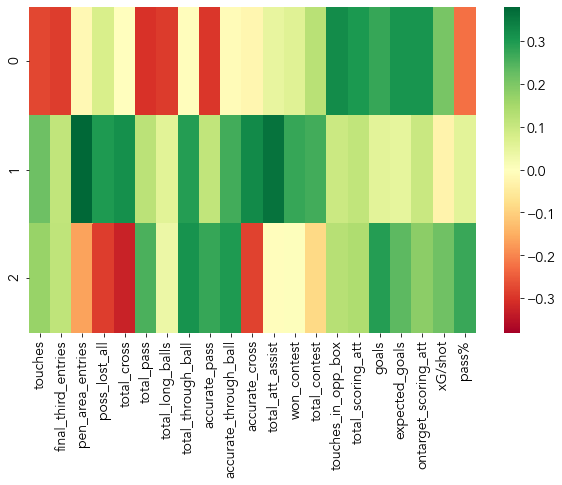

In [1174]:
fig = plt.figure(figsize=(10,6))
vlim = max(np.abs(comp_rel.min()),np.abs(comp_rel.max()))
sns.heatmap(comp_rel,vmin=-vlim,vmax=vlim,yticklabels=np.arange(0,len(comp_rel),1),xticklabels=pca_attr,cmap='RdYlGn')